# MS&E 330: Law, Order, and Algorithms
## Tests for discrimination (outcome and threshold tests)

In [40]:
options(digits = 3)

library(tidyverse)
library(rstan)

stop_df <- read_rds("../data/nc_sample.rds")
population <- read_rds("../data/nc_population.rds")

PATH_TO_STAN_MODEL <- ""

theme_set(theme_bw())

## The data

The loaded data frame `stop_df` is a sample of traffic stops in North Carolina, consisting of 1 million traffic stops from 2009-2015 across the top 100 most active police departments in the state. 
Below is a list of columns in the `stop_df` data:

* Base information regarding stop:
    * `date`, `time`, 
      `police_department`
* Circumstances which led to stop:
    * `reason_for_stop`   
* Suspect demographics:
    * `driver_age`, `driver_gender`, `driver_race`
* Was person searched?: `searched_conducted`,
    * if yes: `reason_for_search`, `search_basis`
* Was contraband found?: `contraband_found`     
* Stop outcome: `arrest_made`, `citation_issued`, `warning_issued`
      
The `population` data frame contains statewide populations by race, using the US 
Census Bureau's ACS 5-year estimates (2012-2016). There are just two columns in
this data frame: `race` and `population`.

## Introduction

A seemingly straightforward way to check if ... (todo: finish intro)

Let's take state highway patrol stops in North Carolina as a case study. 
First, let's check stop counts by race.

In [41]:
# WRITE CODE HERE
# START solution
stop_df %>% count(driver_race)
# START solution

driver_race,n
asian,15557
black,405129
hispanic,85396
white,493918


From the raw numbers, we see there are fewer stops of minority drivers than
of white drivers. However, we need to put these counts in context in order 
to truly understand whether minority drivers are being stopped dispropotionately. 
An initial check could be
the base population. Try computing the per-capita stop rates by race:

In [42]:
# WRITE CODE HERE
# START solution
stop_df %>% 
  count(driver_race) %>% 
  left_join(
    population,
    by = c("driver_race" = "race")
  ) %>% 
  mutate(stop_rate = n / population)
# END solution

driver_race,n,population,stop_rate
asian,15557,258118,0.0603
black,405129,2104597,0.1925
hispanic,85396,884763,0.0965
white,493918,6361438,0.0776


Clearly black and Hispanic individuals are stopped at a much higher rate than
white individuals relative to the residential population in North Carolina. However, the
argument could be made that black individuals are stopped more often then white individuals 
because they exhibit suspicious behavior at higher rates than white individuals. The implication of 
this statement is that instead of comparing the racial distribution of stops to the base racial 
distribution of population, we should be comparing (or "benchmarking") to the underlying racial 
distribution of suspicious behavior being exhibited. 

However, the underlying distribution of who is exhibiting suspicious behavior is nearly impossible 
to obtain. Some common proxies include benchmarking to arrests
or violent arrests. However, those are both problematic for a variety of reasons.

**Discuss with a partner:** Why might using arrests or violent arrests be problematic? What benefits, drawbacks, and assumptions come with each of these two benchmarks?

## The outcome test

The outcome test, first proposed by Gary Becker in 1957, gets around the "benchmarking problem" by focusing on differences in stop outcome (for example, recovery of weapons), and checking if outcomes differ systematically between whites and minorities. If stopped minorities are less likely than whites to have weapons, it suggests that the bar for stopping minorities is lower than the bar for stopping whites. That lower bar is de facto descrimination.

**Discuss with a partner:** How could the outcome test be applied to test discrimination/bias in the case of lending decisions? Bail bond-setting decisions? Editorial acceptance decisions? What would evidence of bias against minorities look like in each of these three decision-making arenas?

Jumping back to our North Carolina data, to apply the outcome test, we want to compute contraband recovery rates (or "hit rates") by race. 

In [43]:
# Compute hit rates by race: number contraband_found / number search_conducted
# WRITE CODE HERE
# START solution
stop_df %>%
  filter(search_conducted) %>%
  group_by(driver_race) %>%
  summarize(hit_rate = sum(contraband_found) / n())
# END solution

driver_race,hit_rate
asian,0.230
black,0.297
hispanic,0.204
white,0.335


We do see that the hit rates among minority drivers are lower than among white drivers. 

What if stop policies vary by location? It's possible that different police departments in the state encourage more or less stringent standards of suspicion prior to conducting searches. By aggregating all departments, we are 

In [44]:
# Compute hit rates by race and department
# Save your result to `dept_hit_rates_by_race`
# WRITE CODE HERE
# START solution
dept_hit_rates_by_race <-
  stop_df %>%
  filter(search_conducted) %>%
  group_by(driver_race, police_department) %>%
  summarize(hit_rate = sum(contraband_found) / n())
# END solution

At this point, with 400 hit rates to compare (1 for each race and department), we need some way to visualize our findings.

In [51]:
# Reshape data to have a white_rate, minority_rate, and minority_race column
# Save your result to `white_vs_minority_rates`
# Hint: the `spread()` and `gather()` functions might be helpful.
# WRITE CODE HERE
# START solution
white_vs_minority_rates <-
  dept_hit_rates_by_race %>%
  spread(driver_race, hit_rate) %>%
  rename(white_rate = white) %>%
  gather(minority_race, minority_rate, c(black, hispanic, asian)) %>%
  filter(!is.na(minority_rate), !is.na(white_rate)) 
# END solution

To visualize these points...

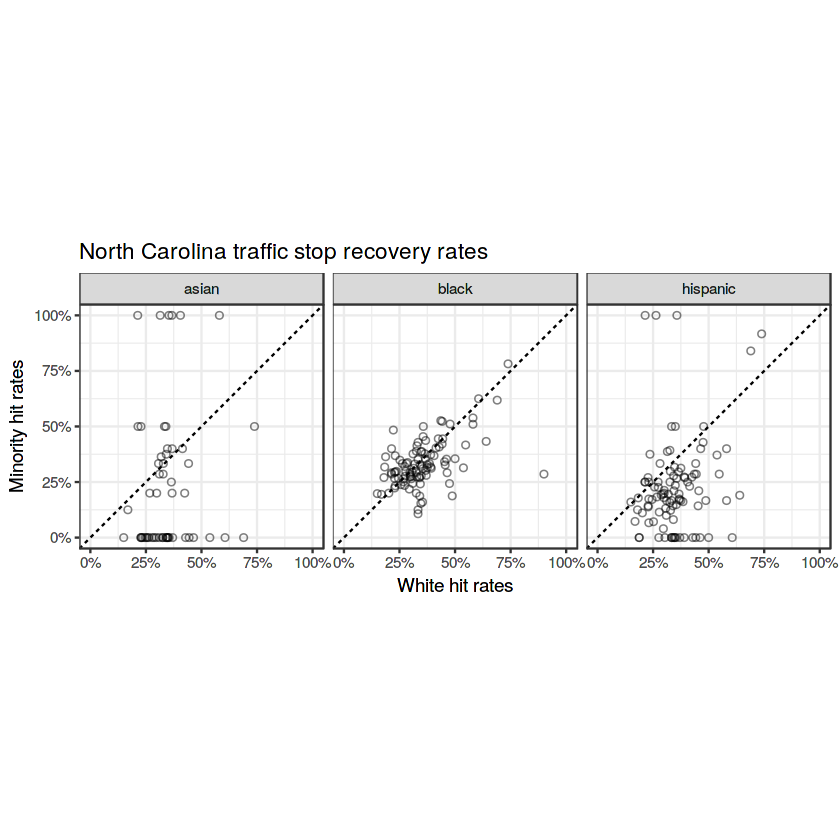

In [89]:
# Plot the data in white_vs_minority_rates
# Hint: `facet_grid()`, `coord_fixed()`, and equal x- and y-axis limits will help make things pretty!
# WRITE CODE HERE
# START solution
white_vs_minority_rates %>%
  ggplot(aes(x = white_rate, y = minority_rate)) +
  geom_point(shape = 1, alpha = 0.5) +
  geom_abline(linetype = "dashed") +
  facet_grid(cols = vars(minority_race)) +
  coord_fixed() +
  scale_x_continuous(limits = c(0, 1), labels = scales::percent) +
  scale_y_continuous(limits = c(0, 1), labels = scales::percent) +
  labs(
    x = "White hit rates",
    y = "Minority hit rates",
    title = "North Carolina traffic stop recovery rates"
  )
# END solution

Lots of 0%, 50%, 100% hit rates among Asian drivers...

In [69]:
# Find number of searches for each minority race in each department
# WRITE CODE HERE
# START solution
n_minority_searches <-
  stop_df %>%
  filter(search_conducted) %>%
  count(driver_race, police_department) %>%
  rename(n_minority_searches = n) %>%
  filter(driver_race != "white")
# END solution

Join the tables...

In [85]:
# Join the two tables together
# WRITE CODE HERE
# START solution
hit_rates <- left_join(
    white_vs_minority_rates,
    n_minority_searches,
    by = c("police_department", "minority_race" = "driver_race")
  )
# END solution

police_department,white_rate,minority_race,minority_rate,n_minority_searches
Blowing Rock Police Department,0.188,hispanic,0.0,1
Cornelius Police Department,0.263,hispanic,1.0,1
Kinston Police Department,0.500,hispanic,0.0,1
New Hanover County Sheriff's Office,0.354,hispanic,0.0,1
Rowan County Sheriff's Office,0.370,hispanic,0.0,1
Asheville Police Department,0.245,asian,0.0,1
Buncombe County Sheriff's Office,0.257,asian,0.0,1
Cabarrus County Sheriff's Office,0.346,asian,0.0,1
Concord Police Department,0.252,asian,0.0,1
Gastonia Police Department,0.690,asian,0.0,1


Plot again, this time using size!

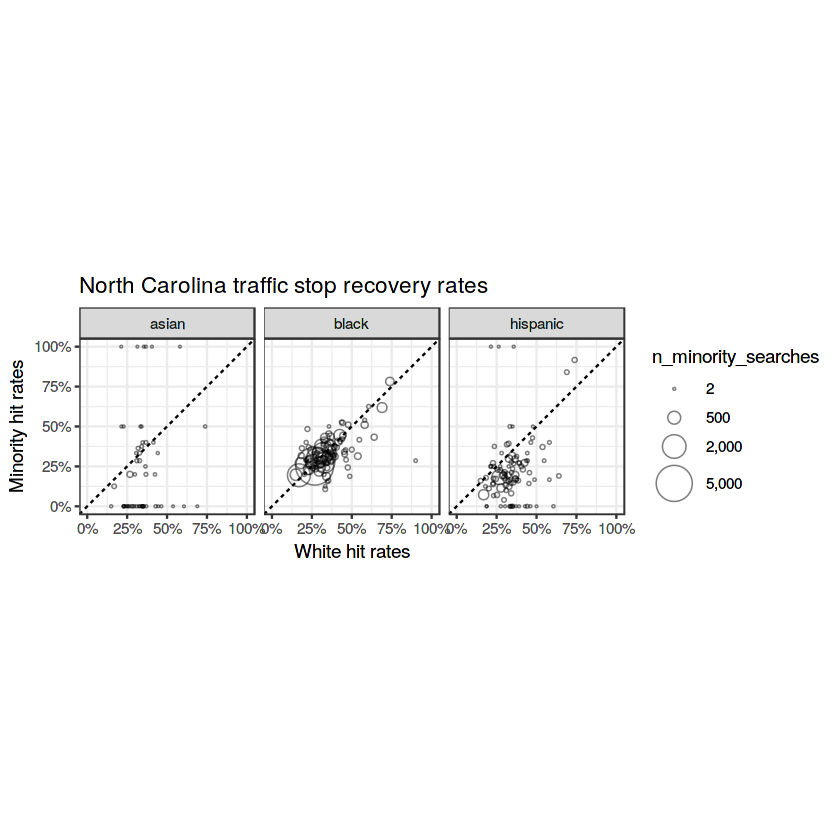

In [91]:
# Recommend arguments for pretty-ifying your size parameter:
# ... + scale_size_area(max_size = 10, labels = scales::comma, breaks = c(2, 500, 2000, 5000)) 
# WRITE CODE HERE
# START solution
hit_rates %>%
  ggplot(aes(x = white_rate, y = minority_rate)) +
  geom_point(aes(size = n_minority_searches), shape = 1, alpha = 0.5) +
  geom_abline(linetype = "dashed") +
  facet_grid(cols = vars(minority_race)) +
  coord_fixed() +
  scale_x_continuous(limits = c(0, 1), labels = scales::percent) +
  scale_y_continuous(limits = c(0, 1), labels = scales::percent) +
  scale_size_area(max_size = 10, labels = scales::comma, breaks = c(2, 500, 2000, 5000)) +
  labs(
    x = "White hit rates",
    y = "Minority hit rates",
    title = "North Carolina traffic stop recovery rates"
  )
# END solution

discuss results

discuss omitted variable bias?

## The threshold test

### A subtle problem: infra-marginality

The outcome test is a great simple and clever way to circumvent omitted variable bias. However, it can at times indicate discrimination where there is none (or indicate lack of discrimination where there is indeed discrimination) through a subtle statistical flaw. First, let's lay out a stylized model to explain officers' behavior at the search-decision. After stopping a driver, officers observe a signal indicating the driver's probability of guilt (possessing contraband). Now consider the following hypothetical scenario:
*  A department has fair, race-neutral policy of conducting a search if a driver's likelihood of guilt exceeds 10%.
*  White drivers exhibit either a 1% or 75% likelihood of guilt. 
*  Black drivers exhibit either a 1% or 50% likelihood of guilt.

In this hypothetical scenario, only white drivers with 75% likelihood of guilt would be searched, and only black drivers iwth 50% likelihood of guilt would be searched. Thus the white hit rate would be 75% and the black hit rate would be 50%. By the outcome test, the lower hit rate among black drivers would indicate discrimination. However, a fair, race-nuetral policy was being employed. 

Let's flesh out this flaw a bit more, considering groups with a more realistic distribution of exhibiting guilt. Suppose there are two groups, a red group and a blue group, with the following search and hit rates:
*  Search rates
    *  Red: 71%
    *  Blue: 64%
*  Hit rates
    *  Red: 39%
    *  Blue: 44%

<img src="../data/images/red_discrimination.png" width="250"><img src="../data/images/blue_discrimination.png" width="250">

The outcome test indicates that in both scenarios, the red group is being discriminated against. This is true in the first scenario, but in the second scenario, the blue group is actually being discriminated against. What went wrong? In the second scenario, there is more blue-group variance, making it easier to distinguish between people of high guilt versus low guilt. In contrast, the red curve has much lower variance: the vast majority of people being stopped exhibit a very similar likelihood of guilt, which is also quite close to the high-low or search-don't search threshold. This is known as the problem of _infra-marginality_.

### A solution: the threshold test

The threshold test employs a hybrid approach to solve the problem of infra-marginality. The test uses observed department-level search and hit rates to simultaneously estimate both the race-specific search thresholds and the signal distributions.

In [146]:
# Create a tibble called `threshold_df` with columns 
# `police_department`, `driver_race`, `n_stops`, `n_searches`, `n_hits`
# WRITE CODE HERE
# START solution
threshold_df <-
  stop_df %>%
  group_by(police_department, driver_race) %>%
  summarize(
    n_stops = n(),
    n_searches = sum(search_conducted),
    n_hits = sum(contraband_found)
  ) %>%
  ungroup()
# END solution

In [150]:
# Run this code to apply the threshold test to your data!

threshold_df <- 
  threshold_df %>%
  ungroup() %>%
  mutate_at(
    vars("police_department", "driver_race"),
    funs(id = as.numeric(factor(.)))
  )

stan_data <-
  list(
    n_groups = nrow(threshold_df),
    n_sub_geographies = n_distinct(pull(threshold_df, police_department)),
    n_races = n_distinct(pull(threshold_df, driver_race)),
    sub_geography = pull(threshold_df, police_department_id),
    race = pull(threshold_df, driver_race_id),
    stop_count = pull(threshold_df, n_stops),
    search_count = pull(threshold_df, n_searches),
    contraband_count = pull(threshold_df, n_hits)
  )

rstan::sampling(
  stan_model(PATH_TO_STAN_MODEL),
  stan_data,
  chains = 5,
  control = list(
    adapt_delta = 0.95,
    adapt_engaged = T,
    max_treedepth = 12
  ),
  cores = min(5, parallel::detectCores() / 2),
  init = "random",
  iter = 5000,
  refresh = 50,
  warmup = 2500
)


In [151]:
stan_data

$n_groups
[1] 400

$n_sub_geographies
[1] 100

$n_races
[1] 4

$sub_geography
  [1]   1   1   1   1   2   2   2   2   3   3   3   3   4   4   4   4   5   5
 [19]   5   5   6   6   6   6   7   7   7   7   8   8   8   8   9   9   9   9
 [37]  10  10  10  10  11  11  11  11  12  12  12  12  13  13  13  13  14  14
 [55]  14  14  15  15  15  15  16  16  16  16  17  17  17  17  18  18  18  18
 [73]  19  19  19  19  20  20  20  20  21  21  21  21  22  22  22  22  23  23
 [91]  23  23  24  24  24  24  25  25  25  25  26  26  26  26  27  27  27  27
[109]  28  28  28  28  29  29  29  29  30  30  30  30  31  31  31  31  32  32
[127]  32  32  33  33  33  33  34  34  34  34  35  35  35  35  36  36  36  36
[145]  37  37  37  37  38  38  38  38  39  39  39  39  40  40  40  40  41  41
[163]  41  41  42  42  42  42  43  43  43  43  44  44  44  44  45  45  45  45
[181]  46  46  46  46  47  47  47  47  48  48  48  48  49  49  49  49  50  50
[199]  50  50  51  51  51  51  52  52  52  52  53  53  53  53  54  54  54  54
[217]  55  55  55  55  56  56  56  56  57  57  57  57  58  58  58  58  59  59
[235]  59  59  60  60  60  60  61  61  61  61  62  62  62  62  63  63  63  63
[253]  64  64  64  64  65  65  65  65  66  66  66  66  67  67  67  67  68  68
[271]  68  68  69  69  69  69  70  70  70  70  71  71  71  71  72  72  72  72
[289]  73  73  73  73  74  74  74  74  75  75  75  75  76  76  76  76  77  77
[307]  77  77  78  78  78  78  79  79  79  79  80  80  80  80  81  81  81  81
[325]  82  82  82  82  83  83  83  83  84  84  84  84  85  85  85  85  86  86
[343]  86  86  87  87  87  87  88  88  88  88  89  89  89  89  90  90  90  90
[361]  91  91  91  91  92  92  92  92  93  93  93  93  94  94  94  94  95  95
[379]  95  95  96  96  96  96  97  97  97  97  98  98  98  98  99  99  99  99
[397] 100 100 100 100

$race
  [1] 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1
 [38] 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2
 [75] 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3
[112] 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4
[149] 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1
[186] 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2
[223] 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3
[260] 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4
[297] 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1
[334] 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2
[371] 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4

$stop_count
  [1]    14  1611   696  2957    41   969   143  2595   224  1862   911  6520
 [13]    62   567   282  2697     6   336   478  1727    65  2332   613  9263
 [25]    16    53    61  1774    11   397   170  1355    26   541   440  5323
 [37]    86  4538  1609  5659    28   449   110  1357   149   693   346  2061
 [49]  1858  5502  1981 16950   581  2219   649  5243  2892 92009 17023 61530
 [61]    28   540   334  1411    34  1629   645  3448   221  6156  2083 12271
 [73]    78   397   462  1435    62   525   206  4452    34  2172   373  2087
 [85]    31   346    69  3857    25   182   200  4166    16   426   252  1204
 [97]    43  2456   557  1746   529 18028  3708  8244    21   841    61  1292
[109]     6   909   257  1928    24  3652   155  3026   663 30353  3292 18589
[121]    80  1854   783  7197    43  1202   424  2750    56  3355   745  4664
[133]    42  1372   337  5709    46  3108   598  4634    65  5114   645  4134
[145]    28  1120   405  1681   973 30086  2875 21825    73  6561   454  6301
[157]   229  4210   941  5368    14    99   120  1642    27   184   411  2586
[169]    15  2531   283  1228   199  2138   775  8200   698 12574  2206 13339
[181]    17  1029   302   914    86  1473   544  4062    43  2358   410  2854
[193]   104  1574   519  5805    60   690   393  1